<a href="https://colab.research.google.com/github/mr-nastik/UrbanSound8k/blob/main/UrbanSound8k_mfcc%2Bmel%2Bstft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH='/content/gdrive/My Drive/urbansound8k/'

In [ ]:
!pip install soundfile
!pip install livelossplot

In [ ]:
#for model creation
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from livelossplot import PlotLossesKeras

#for data handaling
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#for calc accuaracy and spliting the data
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

#for sound
import librosa
import librosa.display
import glob 
import skimage
import soundfile as sf
from scipy.io.wavfile import read


import warnings
warnings.filterwarnings('ignore')

In [ ]:
Xstft=np.load(PATH+'stft_CNN_ks_X.npy')
Y=np.load(PATH+'stft_CNN_ks_Y.npy')
Xmel=np.load(PATH+'melspectrogram_CNN_128_ks_X.npy')
Xmfcc=np.load(PATH+'mfcc_CNN_60_ks_4s_X.npy')

In [ ]:
print(Xstft.shape,Xmel.shape,Xmfcc.shape)

(8732, 257, 173) (8732, 128, 200) (8732, 60, 173)


In [ ]:
Xmel=Xmel.reshape(-1,128,200,1)
Xstft=Xstft.reshape(-1,257,173,1)
Xmfcc=Xmfcc.reshape(-1,60,173,1)

In [ ]:
xmel_train, xmel_test,xstft_train,xstft_test,xmfcc_train,xmfcc_test, y_train, y_test = train_test_split(Xmel,Xstft,Xmfcc, Y, test_size=0.2, random_state=171210013)
del Xmel
del Xstft
del Xmfcc
del Y

In [ ]:
xmel_train, xmel_val,xstft_train,xstft_val,xmfcc_train,xmfcc_val, y_train, y_val = train_test_split(xmel_train,xstft_train,xmfcc_train, y_train, test_size=0.25, random_state=13)

In [ ]:
print(xmel_train.shape,xmel_test.shape,xmel_val.shape)

(5238, 128, 200, 1) (1747, 128, 200, 1) (1747, 128, 200, 1)


In [ ]:
print(xstft_train.shape,xstft_test.shape,xstft_val.shape)

(5238, 257, 173, 1) (1747, 257, 173, 1) (1747, 257, 173, 1)


In [ ]:
print(xmfcc_train.shape,xmfcc_test.shape,xmfcc_val.shape)

(5238, 60, 173, 1) (1747, 60, 173, 1) (1747, 60, 173, 1)


In [ ]:
print(y_train.shape,y_test.shape,y_val.shape)

(5238, 10) (1747, 10) (1747, 10)


In [ ]:
inputs= Input(shape=(60,173,1))
model_mfcc=Conv2D(filters=32,kernel_size=(5,5),padding='SAME',activation='relu')(inputs)
model_mfcc=BatchNormalization(momentum=0.2)(model_mfcc)
model_mfcc=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=AveragePooling2D(pool_size=(2,2))(model_mfcc)

model_mfcc=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)

model_mfcc=AveragePooling2D(pool_size=(2,2))(model_mfcc)

model_mfcc=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=AveragePooling2D(pool_size=(2,2))(model_mfcc)

model_mfcc=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=BatchNormalization(momentum=0.2)(model_mfcc)
model_mfcc=AveragePooling2D(pool_size=(2,2))(model_mfcc)

model_mfcc=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mfcc)
model_mfcc=AveragePooling2D(pool_size=(2,2))(model_mfcc)

model_mfcc=Flatten()(model_mfcc)
model_mfcc=Dense(512,activation='relu')(model_mfcc)
model_mfcc=BatchNormalization(momentum=0.2)(model_mfcc)
model_mfcc=Dense(64,activation='relu')(model_mfcc)
model_mfcc=BatchNormalization(momentum=0.2)(model_mfcc)

output=Dense(10,activation='softmax',name='output')(model_mfcc)

model_mfcc=Model(inputs=inputs,outputs=[output])

In [ ]:
model_mfcc.summary()
model_mfcc.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 173, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 173, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 173, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 173, 32)       9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 173, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 173, 32)       9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 173, 32)       9248  

In [ ]:
model_mfcc.load_weights(PATH+'model_mfcc.hdf5')
x1_train=model_mfcc.predict(xmfcc_train)
x1_test=model_mfcc.predict(xmfcc_test)
x1_val=model_mfcc.predict(xmfcc_val)

In [ ]:
print(x1_train.shape)

(5238, 10)


In [ ]:
inputs= Input(shape=(128,200,1))
model_mel=Conv2D(filters=32,kernel_size=(5,5),padding='SAME',activation='relu')(inputs)
model_mel=BatchNormalization(momentum=0.2)(model_mel)
model_mel=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=AveragePooling2D(pool_size=(2,2))(model_mel)

model_mel=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)

model_mel=AveragePooling2D(pool_size=(2,2))(model_mel)

model_mel=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=AveragePooling2D(pool_size=(2,2))(model_mel)

model_mel=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=BatchNormalization(momentum=0.2)(model_mel)
model_mel=AveragePooling2D(pool_size=(2,2))(model_mel)

model_mel=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_mel)
model_mel=AveragePooling2D(pool_size=(2,2))(model_mel)

model_mel=Flatten()(model_mel)
model_mel=Dense(512,activation='relu')(model_mel)
model_mel=BatchNormalization(momentum=0.2)(model_mel)
model_mel=Dense(64,activation='relu')(model_mel)
model_mel=BatchNormalization(momentum=0.2)(model_mel)

output=Dense(10,activation='softmax',name='output')(model_mel)

model_mel=Model(inputs=inputs,outputs=[output])

In [ ]:
model_mel.summary()
model_mel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 200, 1)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 200, 32)      832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 200, 32)      128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 200, 32)      9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 200, 32)      9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 200, 32)      9248      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 200, 32)      9248

In [ ]:
model_mel.load_weights(PATH+'model_melspectrum.hdf5')
x2_train=model_mel.predict(xmel_train)
x2_test=model_mel.predict(xmel_test)
x2_val=model_mel.predict(xmel_val)

In [ ]:
inputs= Input(shape=(257,173,1))
model_stft=Conv2D(filters=32,kernel_size=(5,5),padding='SAME',activation='relu')(inputs)
model_stft=BatchNormalization(momentum=0.2)(model_stft)
model_stft=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=AveragePooling2D(pool_size=(2,2))(model_stft)

model_stft=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)

model_stft=AveragePooling2D(pool_size=(2,2))(model_stft)

model_stft=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=AveragePooling2D(pool_size=(2,2))(model_stft)

model_stft=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=BatchNormalization(momentum=0.2)(model_stft)
model_stft=AveragePooling2D(pool_size=(2,2))(model_stft)

model_stft=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model_stft)
model_stft=AveragePooling2D(pool_size=(2,2))(model_stft)

model_stft=Flatten()(model_stft)
model_stft=Dense(512,activation='relu')(model_stft)
model_stft=BatchNormalization(momentum=0.2)(model_stft)
model_stft=Dense(64,activation='relu')(model_stft)
model_stft=BatchNormalization(momentum=0.2)(model_stft)

output=Dense(10,activation='softmax',name='output')(model_stft)

model_stft=Model(inputs=inputs,outputs=[output])

In [ ]:
model_stft.summary()
model_stft.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 257, 173, 1)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 257, 173, 32)      832       
_________________________________________________________________
batch_normalization_8 (Batch (None, 257, 173, 32)      128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 257, 173, 32)      9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 257, 173, 32)      9248      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 257, 173, 32)      9248      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 257, 173, 32)      9248

In [ ]:
model_stft.load_weights(PATH+'model_stft.hdf5')
x3_train=model_stft.predict(xstft_train)
x3_test=model_stft.predict(xstft_test)
x3_val=model_stft.predict(xstft_val)

In [ ]:
x_train=np.concatenate((x1_train,x2_train,x3_train),axis=1)
x_test=np.concatenate((x1_test,x2_test,x3_test),axis=1)
x_val=np.concatenate((x1_val,x2_val,x3_val),axis=1)

In [ ]:
print(x_train[1])

[2.9407877e-02 1.2121362e-03 5.6256070e-03 1.5947640e-04 8.5347581e-01
 2.0338469e-03 3.1406238e-05 1.8638015e-02 1.1722579e-03 8.8243656e-02
 1.9020634e-09 2.0432072e-08 2.2677979e-07 1.1387027e-08 9.9999952e-01
 3.8721819e-08 7.7574512e-08 1.4107764e-08 1.2524484e-07 2.5009795e-08
 2.3162467e-04 7.1744160e-03 1.1080190e-03 1.1842403e-05 9.4037980e-01
 3.5642987e-04 1.0532330e-03 3.7655041e-02 1.7351427e-04 1.1856039e-02]


In [ ]:
print(x1_train[1],x2_train[1],x3_train[1])

[2.9407877e-02 1.2121362e-03 5.6256070e-03 1.5947640e-04 8.5347581e-01
 2.0338469e-03 3.1406238e-05 1.8638015e-02 1.1722579e-03 8.8243656e-02] [1.9020634e-09 2.0432072e-08 2.2677979e-07 1.1387027e-08 9.9999952e-01
 3.8721819e-08 7.7574512e-08 1.4107764e-08 1.2524484e-07 2.5009795e-08] [2.3162467e-04 7.1744160e-03 1.1080190e-03 1.1842403e-05 9.4037980e-01
 3.5642987e-04 1.0532330e-03 3.7655041e-02 1.7351427e-04 1.1856039e-02]


In [ ]:
M=Sequential()
M.add(Dense(32, input_dim=30, activation='relu'))
M.add(Dropout(0.1))
M.add(Dense(24, activation='relu'))
#M.add(Dropout(0.2))
M.add(Dense(16, activation='relu'))
M.add(Dropout(0.1))
M.add(Dense(10, activation='softmax'))

In [ ]:
M.summary()
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
mcp_save = ModelCheckpoint(PATH+'model_new.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-5, mode='min')

M.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                992       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                170       
Total params: 2,354
Trainable params: 2,354
Non-trainable params: 0
______________________________________________________

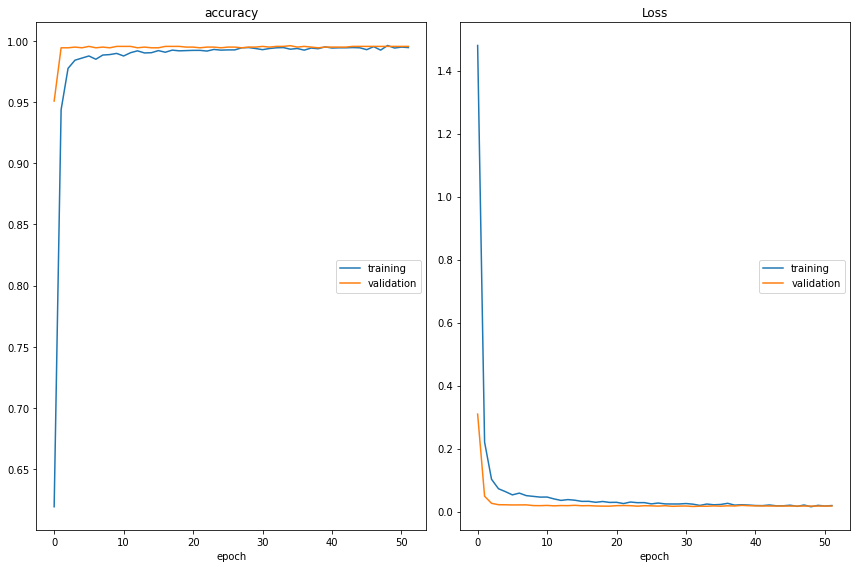

accuracy
	training         	 (min:    0.619, max:    0.996, cur:    0.994)
	validation       	 (min:    0.951, max:    0.996, cur:    0.995)
Loss
	training         	 (min:    0.016, max:    1.480, cur:    0.019)
	validation       	 (min:    0.016, max:    0.310, cur:    0.018)
Epoch 00052: early stopping


In [ ]:
M.fit(x_train, y_train,
          epochs=200,
          callbacks=[PlotLossesKeras(), earlyStopping, mcp_save, reduce_lr_loss],
          verbose=1,
          validation_data=(x_val, y_val))

In [ ]:
score = M.evaluate(x_test, y_test)
print(score)

55/55 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 0.9445
[0.3743962049484253, 0.9444762468338013]


In [ ]:
M.load_weights(PATH+'model_new.hdf5')
score = M.evaluate(x_test, y_test)
print(score)

55/55 [==============================] - 0s 2ms/step - loss: 0.3519 - accuracy: 0.9445
[0.35189884901046753, 0.9444762468338013]
